In [1]:
%matplotlib inline
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import simtk.openmm as mm
from msmbuilder.decomposition import tICA, PCA

In [3]:
dataFull = np.loadtxt('ala4_explicit/COLVAR_md_explicit_10ns')

In [4]:
data = dataFull[:,1:7]
sumabs=dataFull[:,-1]


In [5]:
print(data)
print(sumabs)

[[-2.401463  2.721934 -1.359381  2.476104 -1.271216  2.361919]
 [-2.341986  2.873031 -1.109471  2.587082 -1.49281  -3.125739]
 [-2.458682  2.601563 -1.365601  2.60777  -1.5563    3.084817]
 ...
 [-1.381258  2.279866 -2.30461   3.077384 -1.124621  2.815719]
 [-1.695112  1.912944 -1.793466  2.932431 -1.201032  2.709006]
 [-1.37564   1.898676 -1.830701  2.715888 -0.99448   2.054822]]
[0.758897 0.759956 0.749528 ... 0.463711 0.542259 0.610034]


In [6]:
sincos=[]

for i in range(0,len(data)):
    temp=[]
    for j in range(0,6):
        temp.append(np.sin(data[i,j]))
        temp.append(np.cos(data[i,j]))
    sincos.append(temp)

diheds_sincos=np.array(sincos)

In [7]:
fe = np.loadtxt('ala4_explicit/fe')
print(fe)

[1.397509  1.983793  1.776999  ... 1.375204  0.9172205 1.062112 ]


In [8]:
X = sumabs
X_dihed = diheds_sincos
y = fe

xnew_sincos=[]
xnew=[]
ynew=[]
for i in range(0,len(X)):
    t1=[]
    t1.append(X[i])
    xnew.append(t1)
    t2=[]
    #t2.append(y[i])
    #ynew.append(t2)
    t3=[]
    for j in range(0,12):
        t3.append(X_dihed[i][j])
    xnew_sincos.append(t3)

xnew=np.array(xnew)
#ynew=np.array(ynew)
xnew_sincos=np.array(xnew_sincos)

print(xnew_sincos[0])
sum(xnew_sincos[:,0])

[-0.67438365 -0.73838113  0.40744875 -0.91322807 -0.9777349   0.20984392
  0.61744359 -0.78661516 -0.95546043  0.29511925  0.70304738 -0.71114301]


-41869.03006544425

In [9]:
x_sincos_centered=xnew_sincos

for i in range(0,len(xnew_sincos[0])):
    avg=sum(xnew_sincos[:,i])/len(xnew_sincos)
    print(avg)
    x_sincos_centered[:,i]=x_sincos_centered[:,i]-avg
    
print(x_sincos_centered[0])

-0.8373638540318044
-0.11089574722092439
0.3988736246362931
-0.6151028330760221
-0.8623292715556716
-0.05009631871410182
0.22080465483150075
-0.28863031532459527
-0.8339834437230369
-0.1470649727591676
0.33971750888719676
-0.49980440773681223
[ 0.1629802  -0.62748538  0.00857513 -0.29812524 -0.11540562  0.25994024
  0.39663893 -0.49798485 -0.12147698  0.44218422  0.36332987 -0.21133861]


In [10]:
import sklearn
from sklearn.cross_validation import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_sincos_centered, sumabs, test_size=0.2, random_state=42)

print(x_train.shape, y_train.shape,y_test.shape )

(40000, 12) (40000,) (10001,)


In [11]:
import tensorflow as tf
import numpy as np
print(tf.__version__)
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras import backend as K
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model

2.1.0


Using TensorFlow backend.


In [42]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [139]:
def circular(args):
    
    z_circular = args
    #print(z_circular)
    #print(K.sum(K.square(z_circular),axis=-1,keepdims=True))
    return z_circular/K.sqrt(K.sum(K.square(z_circular),axis=-1,keepdims=True))
    
    

In [180]:
#This is not working yet as in tensorflow there isnt a direct wat to select coloums 

def circular_out(args):
    
    out = args
    
    print(out)
    A = tf.Variable(out)
    index = tf.Variable([0, 1, 2, 3, 4, 5])

    one_hot_mask = tf.one_hot(index, A.shape[1], on_value = True, off_value = False, dtype = tf.bool)
    output = tf.boolean_mask(A, one_hot_mask)
    print(output)
    print(output[1])
    

In [181]:
def new_sampling(args):
    
    z_circular, z_log_var = args
    
    

In [182]:
original_dim=12
inputs = Input(shape=(original_dim,),name='encoder_input')
latent_dim = 2
batch_size=100
epochs=500

    
x = Dense(8)(inputs)
x = Dense(4, activation='tanh')(x)
 
z_mean = Dense(latent_dim,activation='tanh',name='z_mean')(x)
z_log_var = Dense(latent_dim,activation='tanh', name='z_log_var')(x)

#z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
z_circular = Lambda(circular, output_shape=(latent_dim,), name='z_circular')(z_mean)
#z = Lambda(new_sampling, output_shape=(latent_dim,), name='z')([z_circular, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z_circular], name='encoder')

encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
    
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(4, activation='tanh')(latent_inputs)
x = Dense(8, activation='tanh')(x)
#outputs = Dense(original_dim)(x)
out1= Dense(original_dim)(x)
outputs = Lambda(circular_out, output_shape=(latent_dim,), name='output')(out1)
        
        
    
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 12)           0                                            
__________________________________________________________________________________________________
dense_124 (Dense)               (None, 8)            104         encoder_input[0][0]              
__________________________________________________________________________________________________
dense_125 (Dense)               (None, 4)            36          dense_124[0][0]                  
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            10          dense_125[0][0]                  
____________________________________________________________________________________________

ValueError: Tensor-typed variable initializers must either be wrapped in an init_scope or callable (e.g., `tf.Variable(lambda : tf.truncated_normal([10, 40]))`) when building functions. Please file a feature request if this restriction inconveniences you.

In [ ]:

models = (encoder, decoder)
data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss

reconstruction_loss = mse(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

#error_loss = K.square(K.sum(K.square(outputs),axis=-1)-6)
#error_loss *= 0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()





In [183]:
kl_loss.shape

TensorShape([None])

In [104]:
autoencoder_train=vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('vae_explicit_newloss.h5')

Train on 40000 samples, validate on 10001 samples
Epoch 1/500
40000/40000 [==============================] - 1s 21us/step - loss: 1.7737 - val_loss: 1.4711
Epoch 2/500
40000/40000 [==============================] - 1s 14us/step - loss: 1.4560 - val_loss: 1.4579
Epoch 3/500
40000/40000 [==============================] - 1s 16us/step - loss: 1.4435 - val_loss: 1.4384
Epoch 4/500
40000/40000 [==============================] - 1s 15us/step - loss: 1.3976 - val_loss: 1.3528
Epoch 5/500
40000/40000 [==============================] - 1s 14us/step - loss: 1.2978 - val_loss: 1.2545
Epoch 6/500
40000/40000 [==============================] - 1s 14us/step - loss: 1.2255 - val_loss: 1.2029
Epoch 7/500
40000/40000 [==============================] - 1s 14us/step - loss: 1.1823 - val_loss: 1.1900
Epoch 8/500
40000/40000 [==============================] - 1s 14us/step - loss: 1.1436 - val_loss: 1.1203
Epoch 9/500
40000/40000 [==============================] - 1s 18us/step - loss: 1.1046 - val_loss: 1.0

40000/40000 [==============================] - 1s 15us/step - loss: 0.9085 - val_loss: 0.9227
Epoch 78/500
40000/40000 [==============================] - 1s 16us/step - loss: 0.9083 - val_loss: 0.9227
Epoch 79/500
40000/40000 [==============================] - ETA: 0s - loss: 0.9094- ETA: 0s - loss:  - 1s 16us/step - loss: 0.9091 - val_loss: 0.9150
Epoch 80/500
40000/40000 [==============================] - 1s 18us/step - loss: 0.9101 - val_loss: 0.9229
Epoch 81/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.9087 - val_loss: 0.9359
Epoch 82/500
40000/40000 [==============================] - 1s 15us/step - loss: 0.9076 - val_loss: 0.9477
Epoch 83/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.9069 - val_loss: 0.9211
Epoch 84/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.9067 - val_loss: 0.9181
Epoch 85/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.9062 - val_loss: 0.9289
Epoch 8

Epoch 152/500
40000/40000 [==============================] - 1s 15us/step - loss: 0.8897 - val_loss: 0.9090
Epoch 153/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8909 - val_loss: 0.9228
Epoch 154/500
40000/40000 [==============================] - 1s 15us/step - loss: 0.8912 - val_loss: 0.9065
Epoch 155/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8915 - val_loss: 0.9050
Epoch 156/500
40000/40000 [==============================] - 1s 15us/step - loss: 0.8917 - val_loss: 0.9055
Epoch 157/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8924 - val_loss: 0.9005
Epoch 158/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8916 - val_loss: 0.8982
Epoch 159/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8924 - val_loss: 0.9211
Epoch 160/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8933 - val_loss: 0.9099
Epoch 161/500
40000/40000 [=

Epoch 228/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8766 - val_loss: 0.8771
Epoch 229/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8744 - val_loss: 0.8819
Epoch 230/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8768 - val_loss: 0.8843
Epoch 231/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8762 - val_loss: 0.8789
Epoch 232/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8749 - val_loss: 0.9011
Epoch 233/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8777 - val_loss: 0.8818
Epoch 234/500
40000/40000 [==============================] - 1s 15us/step - loss: 0.8759 - val_loss: 0.8765
Epoch 235/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8745 - val_loss: 0.8836
Epoch 236/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8756 - val_loss: 0.8941
Epoch 237/500
40000/40000 [=

Epoch 304/500
40000/40000 [==============================] - 1s 15us/step - loss: 0.8699 - val_loss: 0.8911
Epoch 305/500
40000/40000 [==============================] - 1s 15us/step - loss: 0.8711 - val_loss: 0.8732
Epoch 306/500
40000/40000 [==============================] - 1s 15us/step - loss: 0.8726 - val_loss: 0.8755
Epoch 307/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8691 - val_loss: 0.8891
Epoch 308/500
40000/40000 [==============================] - 1s 16us/step - loss: 0.8695 - val_loss: 0.8913
Epoch 309/500
40000/40000 [==============================] - 1s 18us/step - loss: 0.8716 - val_loss: 0.8760
Epoch 310/500
40000/40000 [==============================] - 1s 18us/step - loss: 0.8700 - val_loss: 0.8755
Epoch 311/500
40000/40000 [==============================] - 1s 17us/step - loss: 0.8694 - val_loss: 0.8753
Epoch 312/500
40000/40000 [==============================] - 1s 19us/step - loss: 0.8724 - val_loss: 0.8816
Epoch 313/500
40000/40000 [=

40000/40000 [==============================] - 1s 17us/step - loss: 0.8673 - val_loss: 0.8700
Epoch 380/500
40000/40000 [==============================] - 1s 17us/step - loss: 0.8680 - val_loss: 0.8697
Epoch 381/500
40000/40000 [==============================] - 1s 16us/step - loss: 0.8690 - val_loss: 0.8737
Epoch 382/500
40000/40000 [==============================] - 1s 15us/step - loss: 0.8658 - val_loss: 0.8758
Epoch 383/500
40000/40000 [==============================] - 1s 15us/step - loss: 0.8670 - val_loss: 0.8662
Epoch 384/500
40000/40000 [==============================] - 1s 15us/step - loss: 0.8648 - val_loss: 0.9562
Epoch 385/500
40000/40000 [==============================] - 1s 16us/step - loss: 0.8700 - val_loss: 0.8958
Epoch 386/500
40000/40000 [==============================] - 1s 17us/step - loss: 0.8663 - val_loss: 0.8937
Epoch 387/500
40000/40000 [==============================] - 1s 15us/step - loss: 0.8672 - val_loss: 0.8749
Epoch 388/500
40000/40000 [===============

Epoch 455/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8616 - val_loss: 0.8645
Epoch 456/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8626 - val_loss: 0.8701
Epoch 457/500
40000/40000 [==============================] - 1s 15us/step - loss: 0.8618 - val_loss: 0.8679
Epoch 458/500
40000/40000 [==============================] - 1s 19us/step - loss: 0.8637 - val_loss: 0.8778
Epoch 459/500
40000/40000 [==============================] - 1s 16us/step - loss: 0.8631 - val_loss: 0.9068
Epoch 460/500
40000/40000 [==============================] - 1s 17us/step - loss: 0.8629 - val_loss: 0.8655 ETA: 0s - loss: 0.8
Epoch 461/500
40000/40000 [==============================] - 1s 18us/step - loss: 0.8604 - val_loss: 0.8718
Epoch 462/500
40000/40000 [==============================] - 1s 18us/step - loss: 0.8632 - val_loss: 0.8827
Epoch 463/500
40000/40000 [==============================] - 1s 16us/step - loss: 0.8623 - val_loss: 0.8702
Epoch 46

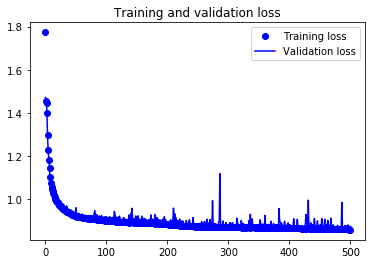

In [105]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs_plot = range(epochs)
plt.figure()
plt.plot(epochs_plot, loss, 'bo', label='Training loss')
plt.plot(epochs_plot, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

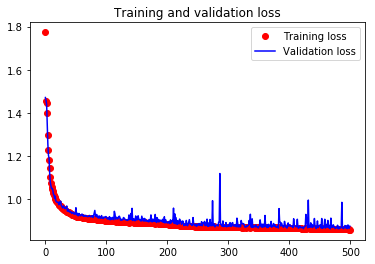

In [106]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs_plot = range(epochs)
plt.figure()
plt.plot(epochs_plot, loss, 'ro', label='Training loss')
plt.plot(epochs_plot, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [107]:
pred = vae.predict(x_test)

In [108]:
pred.shape

(10001, 12)

In [109]:
z_test = encoder.predict(x_test, batch_size=batch_size)

In [110]:
z_test

[array([[ 0.03083431, -0.10710866],
        [-0.07391798,  0.00371354],
        [ 0.06499842, -0.04653018],
        ...,
        [ 0.0651031 , -0.12387206],
        [ 0.06737721,  0.08905193],
        [-0.08938667,  0.12221874]], dtype=float32),
 array([[-7.1237667e-04, -7.1236951e-04],
        [ 6.9048093e-04,  6.9050409e-04],
        [ 4.1080106e-04,  4.1081701e-04],
        ...,
        [-3.0028354e-05, -3.0014546e-05],
        [-1.1741326e-03, -1.1741321e-03],
        [-4.5773914e-04, -4.5772674e-04]], dtype=float32),
 array([[ 0.27664366, -0.96097267],
        [-0.9987403 ,  0.05017535],
        [ 0.81312513, -0.5820889 ],
        ...,
        [ 0.46522748, -0.8851912 ],
        [ 0.60336614,  0.7974643 ],
        [-0.5903307 ,  0.80716145]], dtype=float32),
 array([[-2.0949028 , -1.7856708 ],
        [-1.9637377 ,  1.5337627 ],
        [ 2.9989245 , -1.4108787 ],
        ...,
        [ 0.23458815, -0.8684434 ],
        [ 1.7129306 ,  1.5621543 ],
        [-0.1480498 , -0.03775948

In [111]:
decoder_test=decoder.predict(z_test[0],batch_size=batch_size)

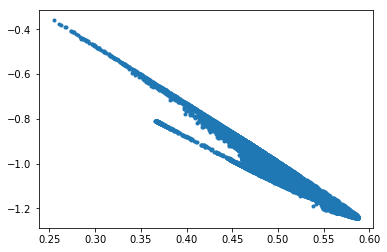

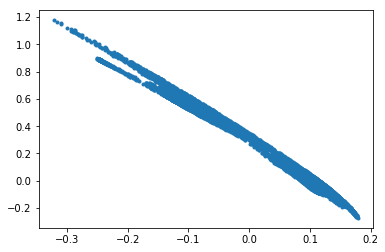

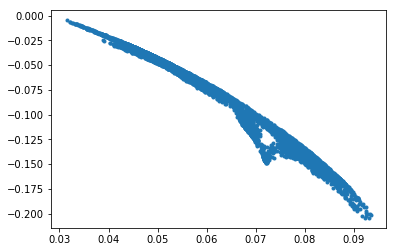

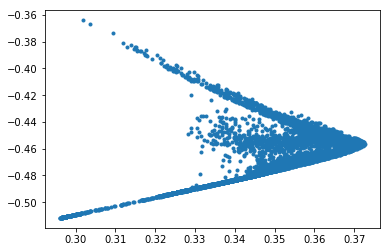

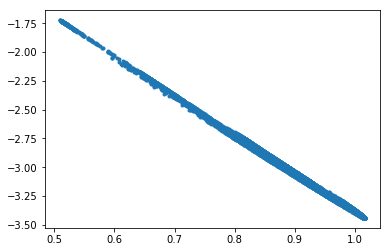

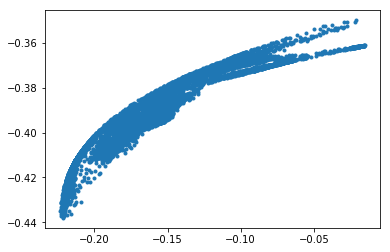

In [132]:
for i in range(6):
    plot(decoder_test[:,i*2],decoder_test[:,i*2+1],'.')
    show()

In [112]:
print(len(decoder_test))

10001


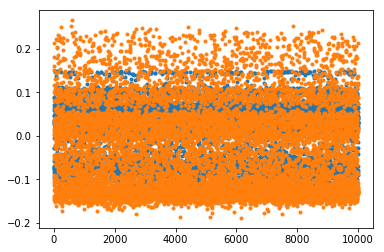

In [122]:
plot(z_test[0][:,0],'.')
plot(z_test[0][:,1],'.')

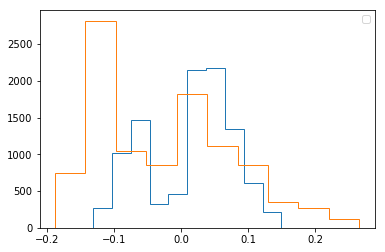

In [125]:
hist(z_test[0][:,0], histtype='step', )
hist(z_test[0][:,1], histtype='step')
legend()

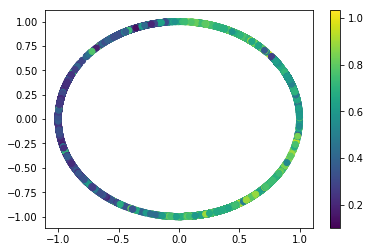

In [114]:

scatter(z_test[2][:,0],z_test[2][:,1],c=y_test)
colorbar()

In [115]:
z_train = encoder.predict(x_train, batch_size=batch_size)

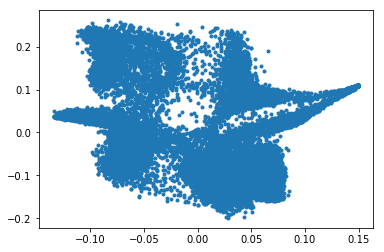

In [119]:
plot(z_train[0][:,0],z_train[0][:,1],'.')


In [34]:
weights = vae.get_weights()

In [35]:
for i in range(14): print(weights[i].shape)

(12, 8)
(8,)
(8, 4)
(4,)
(4, 2)
(2,)
(4, 2)
(2,)
(2, 4)
(4,)
(4, 8)
(8,)
(8, 12)
(12,)


In [36]:
print(weights[0])

[[ 0.53293824 -0.8127838  -0.5383648  -0.00395954  0.26388445  0.08813067
  -0.06117051 -0.22120987]
 [-0.24537683  0.5755422  -0.06220733 -0.57865876 -0.33282748 -0.06498212
   0.14614853 -0.9426079 ]
 [ 0.19131456  0.47305372  0.66185784  0.2895941  -0.36924914  0.3104564
  -1.1184621  -0.1828436 ]
 [ 0.67600846 -0.36847457  0.0518682   0.69920063  0.17892544 -0.27767423
   0.9225629  -0.8988944 ]
 [ 0.56953347 -0.03099505  0.30727965  0.13160244 -0.12482953 -0.0436638
   0.04884087  0.20208348]
 [ 0.190582   -0.48151165  0.16536035  0.03923315  0.10270026  0.18899179
  -0.2003579   0.07406297]
 [ 0.45067596 -0.66222334  0.24499565  0.422542    0.07841898  0.6319722
  -0.139598   -0.23172358]
 [ 0.07170052  0.09295814  0.22949436 -0.27345914  0.21772954 -0.53101444
  -0.30399856 -0.33753544]
 [ 1.8939806  -1.0756019   1.5984552   0.7483277  -0.42598224  0.55671537
  -0.5182215   0.64419603]
 [-1.7016907   0.5945389  -1.1122066  -0.5881248   0.4874146  -0.55252355
   0.22805063 -0.763

In [37]:
first_layer_weights = weights[0]
first_layer_biases  = weights[1]
second_layer_weights = weights[2]
second_layer_biases  = weights[3]
third_layer_weights = weights[4]
third_layer_biases  = weights[5]

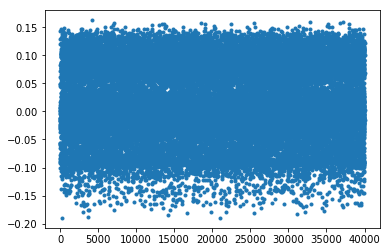

In [42]:
plot(z_train[0][:,1],'.')

In [39]:
np.savetxt('vae_1Dz_explicit_newloss',z_test[0])

[array([[-0.93911064],
       [-0.39859414],
       [-0.44149145],
       ...,
       [ 0.976449  ],
       [ 0.9992952 ],
       [-0.37031013]], dtype=float32)
 array([[-0.40034682],
       [ 0.9995077 ],
       [-0.33660525],
       ...,
       [-0.40768167],
       [-0.34660497],
       [ 0.99965715]], dtype=float32)]


In [56]:
np.savetxt('vae_1Dz_explicit_full',z_test[0])

In [42]:
weights[5]

array([0.2462741], dtype=float32)

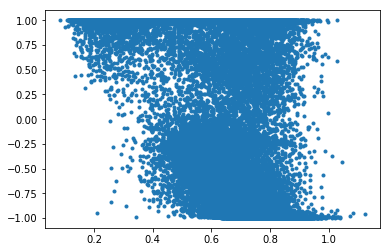

In [26]:
plot(y_train, z_train[0],'.')

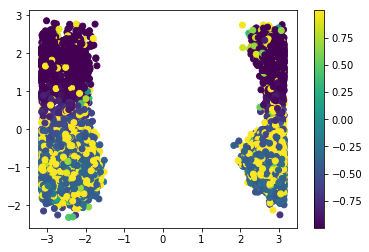

In [44]:
scatter(np.arctan2(x_train[:,1]-0.11089574722092439,x_train[:,0]-0.8373638540318044),np.arctan2(x_train[:,3]
-0.6151028330760221,x_train[:,2]
+ 0.3988736246362931),c=reshape(z_train[0],(40000,)))
colorbar()

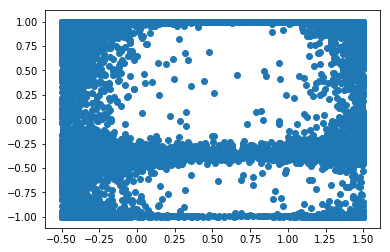

In [45]:
scatter(x_train[:,11],reshape(z_train[0],(40000,)))